In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Define the base directory
base_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


In [5]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
COVID.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [6]:
root_dir ='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")


Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [7]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [8]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [9]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [10]:
# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
for img_path, label in all_mapped_data:
    print(f"Image Path: {img_path}, Label: {label}")
# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1994.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1825.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-517.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-532.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2272.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-765.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-699.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1857.png, Label: 0
Image Path: /kaggle/input/co

In [11]:
# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Mapped DataFrame:


image_path  label
0  /kaggle/input/covid19-radiography-database/COV...      0
1  /kaggle/input/covid19-radiography-database/COV...      0
2  /kaggle/input/covid19-radiography-database/COV...      0
3  /kaggle/input/covid19-radiography-database/COV...      0
4  /kaggle/input/covid19-radiography-database/COV...      0

Total images mapped: 21165


In [12]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")


Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [13]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")


Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [14]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[1] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [15]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 16
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


Training images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


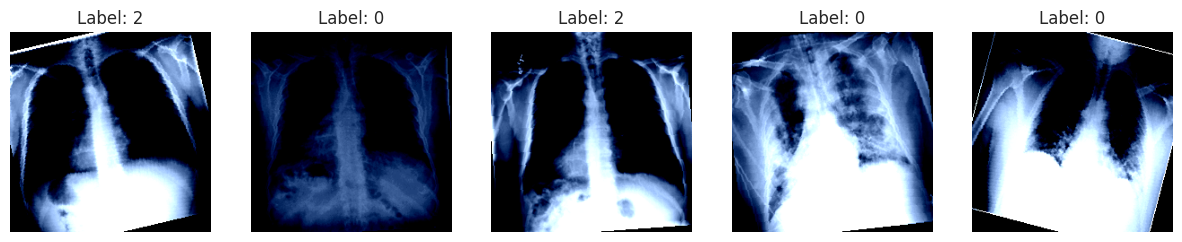

Validation images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


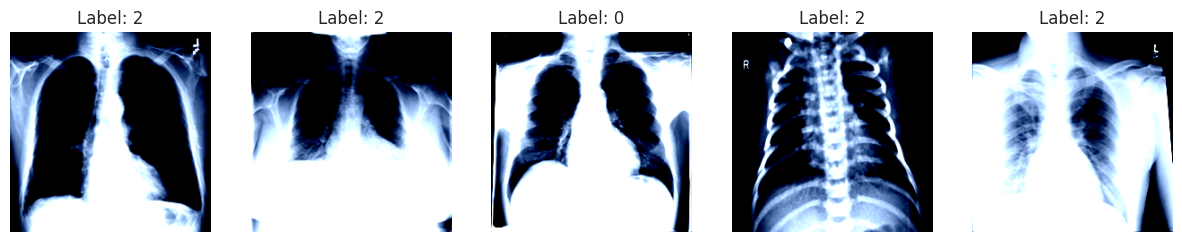

Testing images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


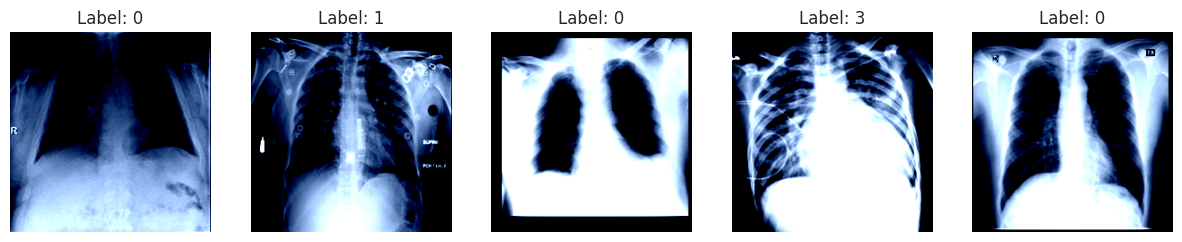

In [16]:
import matplotlib.pyplot as plt

def display_images_from_loader(loader, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Ensure num_images does not exceed batch size
    num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
        print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

    plt.show()

# Check train_loader
print("Training images:")
display_images_from_loader(train_loader)

# Check val_loader
print("Validation images:")
display_images_from_loader(val_loader)

# Check test_loader
print("Testing images:")
display_images_from_loader(test_loader)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import mobilenet_v2

In [34]:
# Define the NonLocalBlock
class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super(NonLocalBlock, self).__init__()
        self.compress = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.expand = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)
    
    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Compress the channel dimension
        compressed = self.compress(x)

        # Perform some operation (e.g., softmax across spatial dimensions)
        compressed_flat = compressed.view(batch_size, -1)
        attention = F.softmax(compressed_flat, dim=1)
        attention = attention.view(batch_size, channels // 2, height, width)
        
        # Element-wise multiplication
        out = attention * compressed

        # Expand back to the original channel dimension
        out = self.expand(out)
        return out + x


In [35]:
# Define the model with MobileNetV2 backbone
class MobileNetV2_NonLocal(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2_NonLocal, self).__init__()
        
        # Load MobileNetV2 backbone
        mobilenet = mobilenet_v2(pretrained=False)
        self.features = mobilenet.features  # Feature extractor
        
        # Add Non-local Block after the feature extractor
        in_channels = mobilenet.last_channel  # Number of output channels from the last feature map
        self.non_local_block = NonLocalBlock(in_channels)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_channels, num_classes)
        )
    
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # Apply Non-local Block
        non_local_features = self.non_local_block(features)
        
        # Global Average Pooling
        pooled = F.adaptive_avg_pool2d(non_local_features, (1, 1))
        pooled = torch.flatten(pooled, 1)
        
        # Classifier
        output = self.classifier(pooled)
        return output

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # Replace with your number of classes
model = MobileNetV2_NonLocal(num_classes).to(device)

# Check model architecture
print(model)

MobileNetV2_NonLocal(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d

In [37]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 926/926 [01:14<00:00, 12.47it/s]


Train Loss: 1.0325, Accuracy: 0.5197


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.91it/s]


Val Loss: 0.8140, Accuracy: 0.6040
End of Epoch 1: Train Loss - 1.0325, Val Loss - 0.8140

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 16.19it/s]


Train Loss: 0.8053, Accuracy: 0.6176


Val Phase: 100%|██████████| 133/133 [00:05<00:00, 26.37it/s]


Val Loss: 0.7303, Accuracy: 0.6427
End of Epoch 2: Train Loss - 0.8053, Val Loss - 0.7303

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 16.07it/s]


Train Loss: 0.7181, Accuracy: 0.6666


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.32it/s]


Val Loss: 0.5821, Accuracy: 0.7212
End of Epoch 3: Train Loss - 0.7181, Val Loss - 0.5821

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 16.03it/s]


Train Loss: 0.6408, Accuracy: 0.7095


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.65it/s]


Val Loss: 0.5452, Accuracy: 0.7694
End of Epoch 4: Train Loss - 0.6408, Val Loss - 0.5452

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.53it/s]


Train Loss: 0.5796, Accuracy: 0.7374


Val Phase: 100%|██████████| 133/133 [00:05<00:00, 26.34it/s]


Val Loss: 0.5115, Accuracy: 0.7580
End of Epoch 5: Train Loss - 0.5796, Val Loss - 0.5115

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.37it/s]


Train Loss: 0.5350, Accuracy: 0.7594


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 28.41it/s]


Val Loss: 0.4441, Accuracy: 0.7788
End of Epoch 6: Train Loss - 0.5350, Val Loss - 0.4441

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.39it/s]


Train Loss: 0.4930, Accuracy: 0.7797


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.30it/s]


Val Loss: 0.4327, Accuracy: 0.7680
End of Epoch 7: Train Loss - 0.4930, Val Loss - 0.4327

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.49it/s]


Train Loss: 0.4662, Accuracy: 0.7947


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 26.84it/s]


Val Loss: 0.3558, Accuracy: 0.8384
End of Epoch 8: Train Loss - 0.4662, Val Loss - 0.3558

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:54<00:00, 16.92it/s]


Train Loss: 0.4448, Accuracy: 0.8036


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 28.18it/s]


Val Loss: 0.3632, Accuracy: 0.8336
End of Epoch 9: Train Loss - 0.4448, Val Loss - 0.3632

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:54<00:00, 16.84it/s]


Train Loss: 0.4149, Accuracy: 0.8190


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.86it/s]


Val Loss: 0.3380, Accuracy: 0.8346
End of Epoch 10: Train Loss - 0.4149, Val Loss - 0.3380

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:54<00:00, 16.87it/s]


Train Loss: 0.3745, Accuracy: 0.8327


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 29.25it/s]


Val Loss: 0.2978, Accuracy: 0.8596
End of Epoch 11: Train Loss - 0.3745, Val Loss - 0.2978

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.41it/s]


Train Loss: 0.3575, Accuracy: 0.8431


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 28.84it/s]


Val Loss: 0.2908, Accuracy: 0.8719
End of Epoch 12: Train Loss - 0.3575, Val Loss - 0.2908

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:55<00:00, 16.65it/s]


Train Loss: 0.3562, Accuracy: 0.8440


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 29.51it/s]


Val Loss: 0.2832, Accuracy: 0.8677
End of Epoch 13: Train Loss - 0.3562, Val Loss - 0.2832

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.47it/s]


Train Loss: 0.3428, Accuracy: 0.8493


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.43it/s]


Val Loss: 0.2837, Accuracy: 0.8672
End of Epoch 14: Train Loss - 0.3428, Val Loss - 0.2837

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 15.97it/s]


Train Loss: 0.3355, Accuracy: 0.8493


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.56it/s]


Val Loss: 0.2852, Accuracy: 0.8625
End of Epoch 15: Train Loss - 0.3355, Val Loss - 0.2852

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.48it/s]


Train Loss: 0.3320, Accuracy: 0.8527


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 27.06it/s]


Val Loss: 0.2778, Accuracy: 0.8733
End of Epoch 16: Train Loss - 0.3320, Val Loss - 0.2778

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 16.15it/s]


Train Loss: 0.3292, Accuracy: 0.8525


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 26.79it/s]


Val Loss: 0.2823, Accuracy: 0.8729
End of Epoch 17: Train Loss - 0.3292, Val Loss - 0.2823

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:55<00:00, 16.55it/s]


Train Loss: 0.3183, Accuracy: 0.8546


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 26.85it/s]


Val Loss: 0.2789, Accuracy: 0.8696
End of Epoch 18: Train Loss - 0.3183, Val Loss - 0.2789

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.32it/s]


Train Loss: 0.3152, Accuracy: 0.8570


Val Phase: 100%|██████████| 133/133 [00:05<00:00, 24.94it/s]


Val Loss: 0.2801, Accuracy: 0.8781
End of Epoch 19: Train Loss - 0.3152, Val Loss - 0.2801

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.35it/s]


Train Loss: 0.3161, Accuracy: 0.8583


Val Phase: 100%|██████████| 133/133 [00:05<00:00, 26.57it/s]


Val Loss: 0.2723, Accuracy: 0.8809
End of Epoch 20: Train Loss - 0.3161, Val Loss - 0.2723

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.47it/s]


Train Loss: 0.3133, Accuracy: 0.8618


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 28.79it/s]


Val Loss: 0.2697, Accuracy: 0.8724
End of Epoch 21: Train Loss - 0.3133, Val Loss - 0.2697

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:57<00:00, 16.23it/s]


Train Loss: 0.3011, Accuracy: 0.8678


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 29.68it/s]


Val Loss: 0.2669, Accuracy: 0.8733
End of Epoch 22: Train Loss - 0.3011, Val Loss - 0.2669

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.53it/s]


Train Loss: 0.3098, Accuracy: 0.8624


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 28.23it/s]


Val Loss: 0.2716, Accuracy: 0.8715
End of Epoch 23: Train Loss - 0.3098, Val Loss - 0.2716

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:56<00:00, 16.50it/s]


Train Loss: 0.3147, Accuracy: 0.8634


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 29.35it/s]


Val Loss: 0.2689, Accuracy: 0.8795
End of Epoch 24: Train Loss - 0.3147, Val Loss - 0.2689

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 926/926 [00:55<00:00, 16.65it/s]


Train Loss: 0.3034, Accuracy: 0.8630


Val Phase: 100%|██████████| 133/133 [00:04<00:00, 26.77it/s]

Val Loss: 0.2649, Accuracy: 0.8800
End of Epoch 25: Train Loss - 0.3034, Val Loss - 0.2649

Training complete. Best Validation Accuracy: 0.8809


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 265/265 [00:16<00:00, 16.34it/s]


Classification Report:
                 precision    recall  f1-score   support

          COVID       0.83      0.93      0.88       723
   Lung_Opacity       0.87      0.83      0.85      1203
         Normal       0.91      0.89      0.90      2039
Viral Pneumonia       0.90      0.99      0.94       269

       accuracy                           0.89      4234
      macro avg       0.88      0.91      0.89      4234
   weighted avg       0.89      0.89      0.89      4234



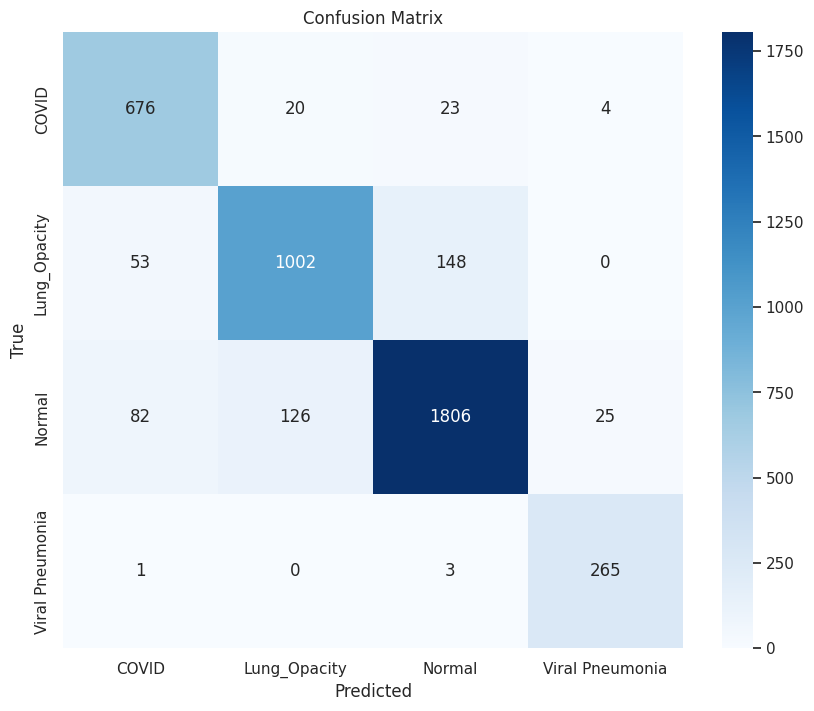

In [40]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

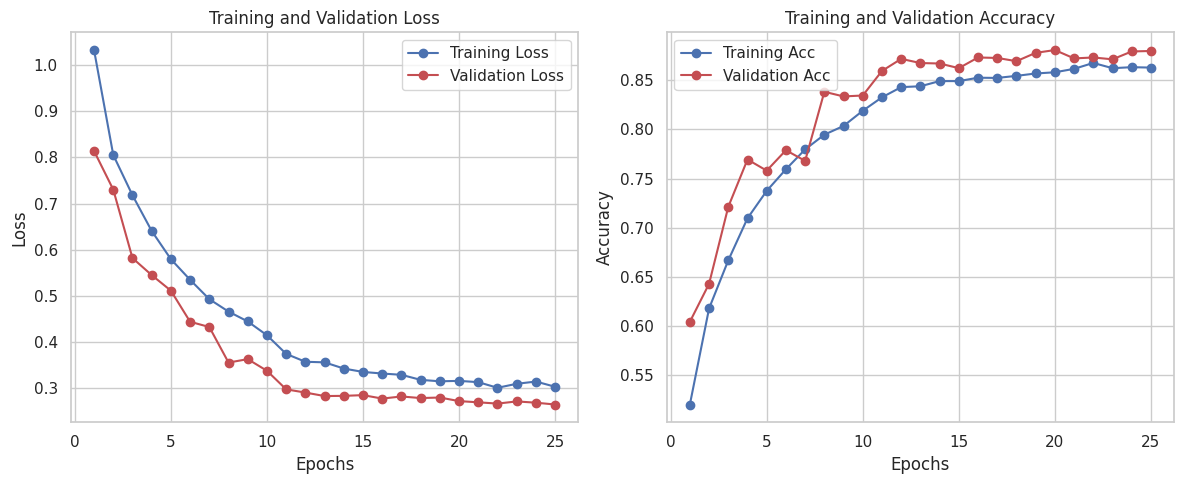

In [41]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

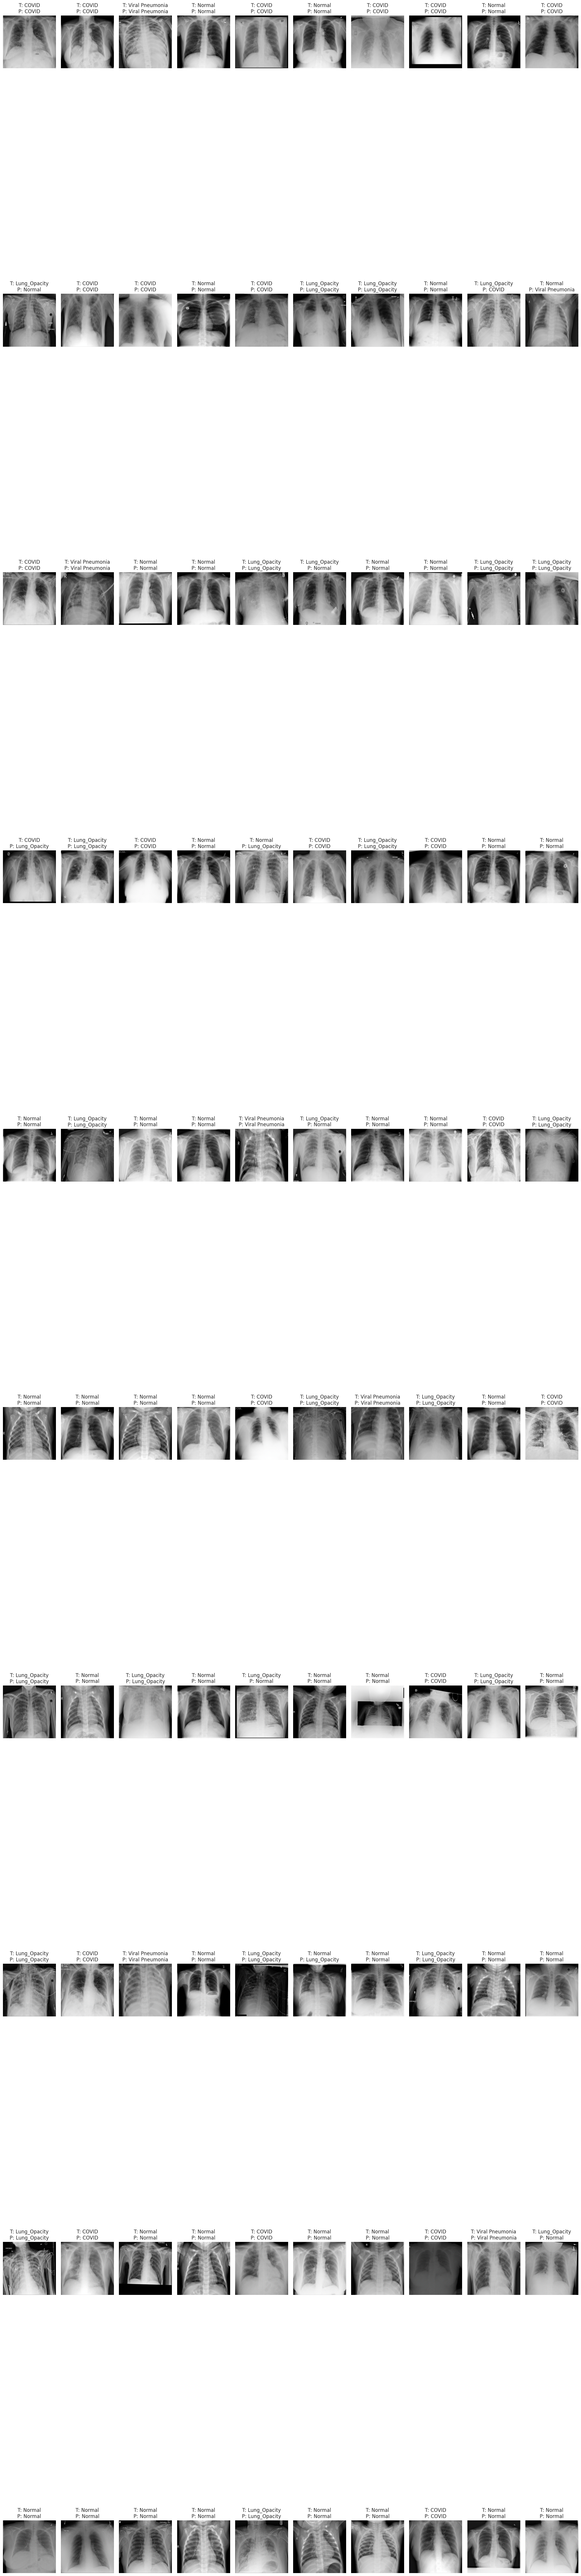

In [42]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
